# **Visualization of Topological Data Analysis - Lab. practice**    

In [ ]:
import numpy as np, random
from matplotlib import pyplot as plt

In [ ]:
# Constants. DO NOT CHANGE.
RANDOM_STATE = 1700

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## **1. Some synthetic data**




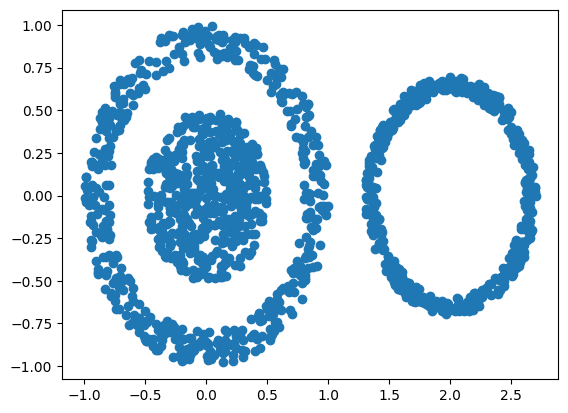

In [ ]:
outer_radius = 1
inner_radius = 0.8
n = 500

rho   = np.sqrt(np.random.uniform(inner_radius**2, outer_radius**2, n))
theta = np.random.uniform(0.0, 2 * np.pi, n)

x = rho * np.cos(theta)
y = rho * np.sin(theta)

outer_radius = 0.5
inner_radius = 0

rho   = np.sqrt(np.random.uniform(inner_radius**2, outer_radius**2, n))
theta = np.random.uniform(0.0, 2 * np.pi, n)

x2 = rho * np.cos(theta)
y2 = rho * np.sin(theta)

outer_radius = 0.7
inner_radius = 0.6

rho   = np.sqrt(np.random.uniform(inner_radius**2, outer_radius**2, n))
theta = np.random.uniform(0.0, 2 * np.pi, n)

x3 = rho * np.cos(theta) + 2.0
y3 = rho * np.sin(theta)

x = np.concatenate((x, x2, x3))
y = np.concatenate((y, y2, y3))

X = np.vstack((x, y)).T

plt.scatter(X[:, 0], X[:, 1])

In [ ]:
from sklearn import datasets

X = datasets.load_iris()["data"]

## **2. TDA**

Note:

*   Topological Data Analysis [scikit-tda](https://scikit-tda.org/)
*   Mapper Algorithm [kmapper](https://kepler-mapper.scikit-tda.org/en/latest/)
*   Persitence Homology [ripser](https://ripser.scikit-tda.org/en/latest/)
*   Persistence Diagram [persim](https://persim.scikit-tda.org/en/latest/)

### **2.1 From data to topology with [neighbor](https://doi.org/10.1016/j.ins.2011.07.043)**

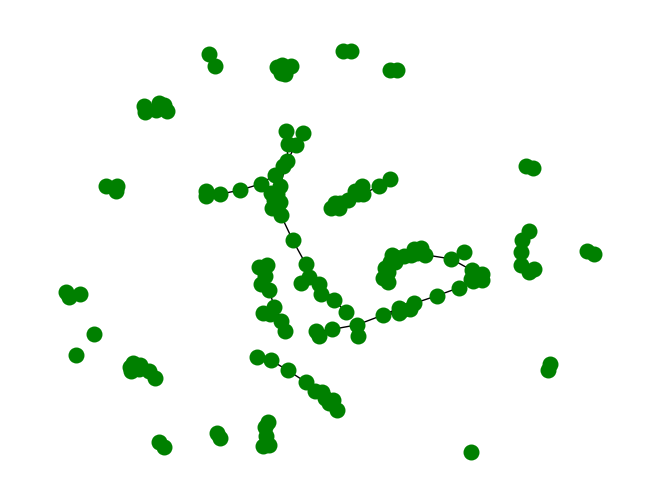

In [ ]:
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances

#distance threshold
epsilon = 0.10

X_dist  = euclidean_distances(X[:150, :])

in_samples = X_dist <= epsilon
out_samples = X_dist > epsilon

#Adjacency matrix
X_dist[in_samples] = 1
X_dist[out_samples]  = 0
np.fill_diagonal(X_dist, 0)

#Graph
G = nx.from_numpy_array(X_dist, create_using = nx.Graph)
nx.draw(G, pos=nx.spring_layout(G, seed=RANDOM_STATE), with_labels = False, linewidths=1.5, node_size=100, node_color = "green")

### **2.2 From data to topology with [Mapper](https://www.youtube.com/watch?v=_tiv0qYcM3U)**

In [ ]:
!pip install kmapper

In [ ]:
import kmapper as km
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [ ]:
#Configure mapper
window_number_point = 15
overlap = 0.3
dist_thresh = 0.5

mapper = km.KeplerMapper(verbose=0)
cover  = km.Cover(window_number_point, overlap)

clusterer = AgglomerativeClustering(n_clusters=None, linkage="single")
clusterer.distance_threshold = (X.max() - X.min()) * dist_thresh

filter_lens = PCA(n_components = 1).fit_transform(X)

#Mapping data
top = mapper.map(X = X, lens = filter_lens, cover = cover, clusterer = clusterer)

In [ ]:
top.keys()

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes'])

In [ ]:
## Map Mapper out into a NetworkX structure
G = nx.Graph()
node_idx = {}

for i, n in enumerate(top["nodes"].keys()):
  node_idx[n] = i
  G.add_node(i)

for origin in top["links"]:
  edges = top["links"][origin]

  for e in edges:
    if e != origin:
      G.add_edge(node_idx[origin], node_idx[e])

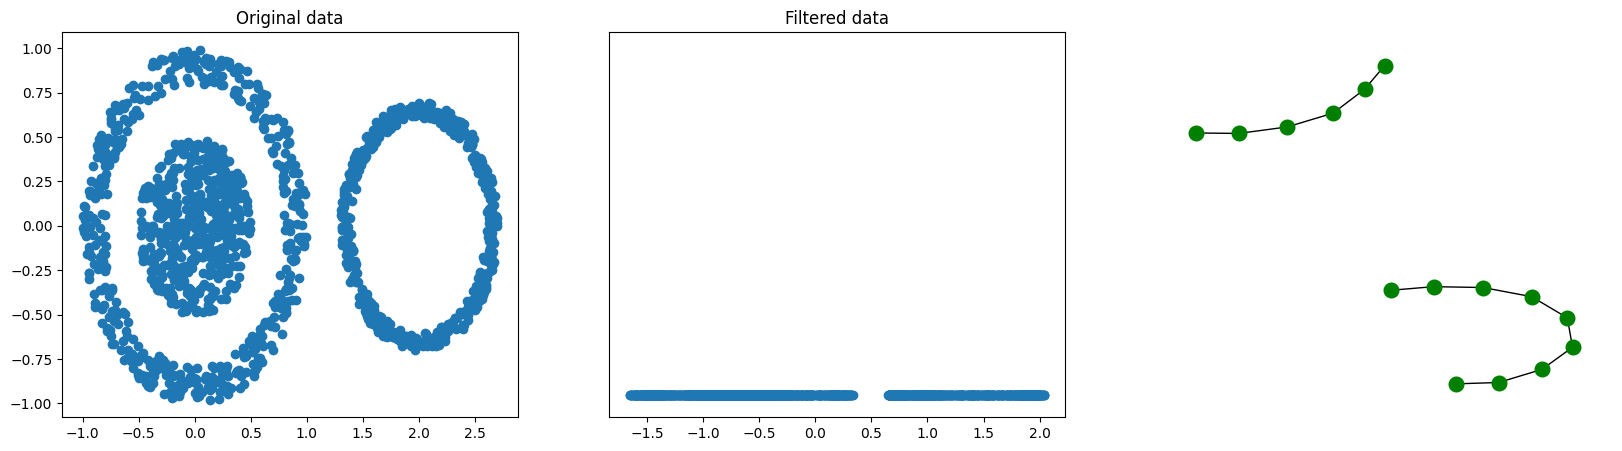

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1])
plt.title("Original data")

plt.subplot(1, 3, 2)
plt.yticks([])
plt.ylim(-0.025, 0.4)
plt.title("Filtered data")
plt.scatter(filter_lens, np.zeros(filter_lens.shape))

plt.subplot(1, 3, 3)
nx.draw(G, pos=nx.spring_layout(G, seed=RANDOM_STATE), with_labels = False, linewidths=1.5, node_size=100, node_color = "green")

### **2.3 From data to topology with [Rips complex](https://comptag.github.io/rpackage_tutorials/2019/07/tda-rips-tutorial.html)**

Note:

> [Persistence Homology](https://www.youtube.com/watch?v=OkDs9Wj5G1U)

> [Barcode vs Point cloud](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-persistence-diagrams.ipynb)

In [ ]:
!pip install ripser persim

In [ ]:
from ripser import ripser
from persim import plot_diagrams, bottleneck

def my_plot(X, diagrams):
  plt.figure(figsize = (20,5))

  plt.subplot(1, 3, 1)
  plt.title('Data')
  plt.scatter(X[:, 0], X[:, 1])

  plt.subplot(1, 3, 2)
  plt.title('0-dim Diagram')
  plot_diagrams(diagrams, plot_only=[0])

  plt.subplot(1, 3, 3)
  plt.title('1-dim Diagram')
  plot_diagrams(diagrams, plot_only=[1])

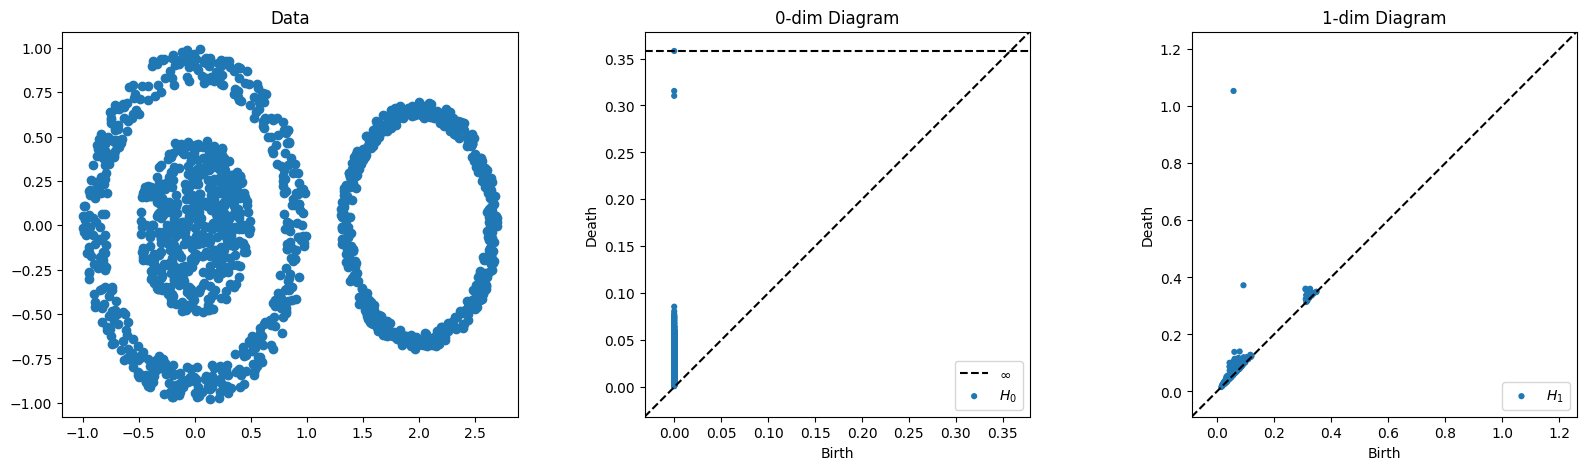

In [ ]:
diagrams = ripser(X)['dgms']
my_plot(X, diagrams)

### **2.4 Persistence diagram from graph**

- H0: connected components
- H1: holes
- H2: voids

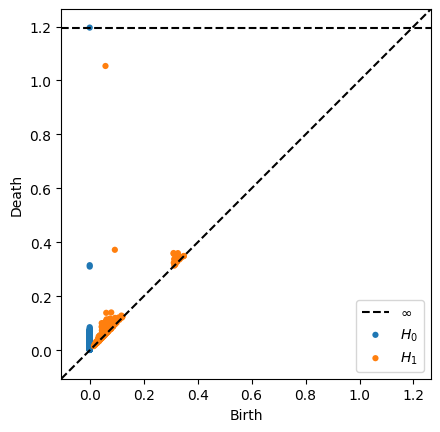

In [ ]:
plot_diagrams(diagrams)

### **2.5 [Distance](https://persim.scikit-tda.org/en/latest/notebooks/distances.html) between Persistence diagrams**

In [ ]:
## Similar graph shows distance = 0
dgm1 = ripser(X)['dgms'][0]
dgm2 = ripser(X)['dgms'][0]

dgm1 = dgm1[np.isfinite(dgm1[:, 1]), :]
dgm2 = dgm2[np.isfinite(dgm2[:, 1]), :]

bottleneck(dgm1, dgm2)

np.float64(0.0)

In [ ]:
## Create a second dataset by adding noise to the original data
np.random.seed(RANDOM_STATE)
samples = np.random.choice(range(X.shape[0]), size=100, replace=False)

X2 = X.copy()
X2[samples, ] = X2[samples, ] + np.random.normal(scale = 0.2, size=X2[samples, ].shape)

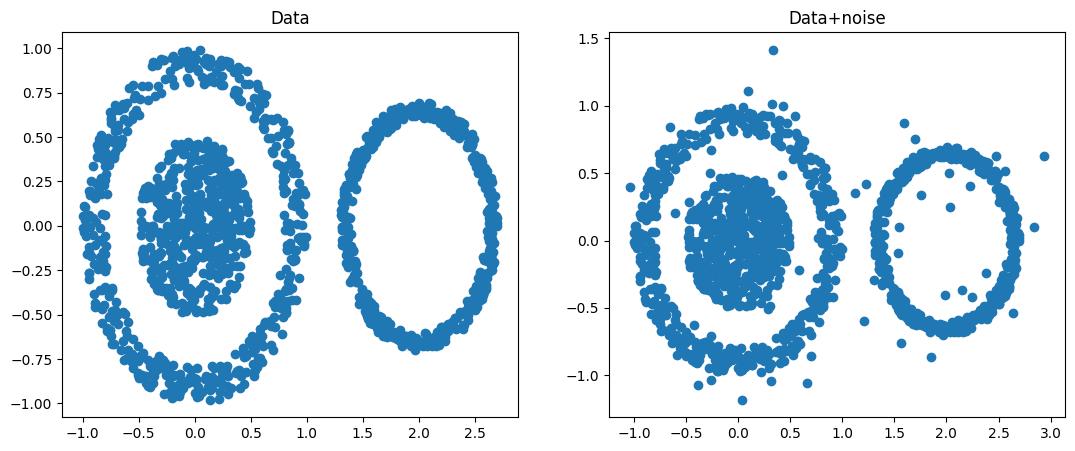

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1, 3, 1)
plt.title('Data')
plt.scatter(X[:, 0], X[:, 1])

plt.subplot(1, 3, 2)
plt.title('Data+noise')
plt.scatter(X2[:, 0], X2[:, 1])

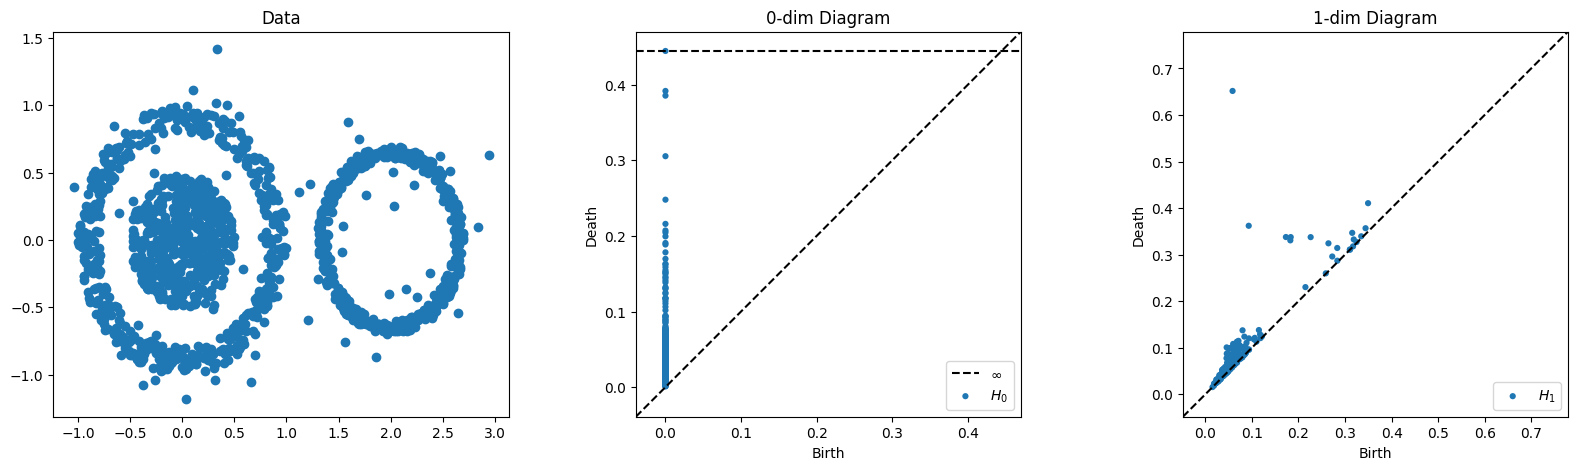

In [ ]:
diagrams2 = ripser(X2)['dgms']
my_plot(X2, diagrams2)

In [ ]:
dgm2 = diagrams2[0]
dgm2 = dgm2[np.isfinite(dgm2[:, 1]), :]

bottleneck(dgm1, dgm2)

np.float64(0.152716264128685)

## **3. More tests**

- Consider toy datasets such as [Iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris) and [Wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) from scikit-learn

```python
from sklearn.datasets import load_iris
X = load_iris()["data"]
```

- Run the previous tests and check the patterns.

    a) Vary the `epsilon` value of the `2.1` test

    b) Do the same with `window_number_point`, `overlap`, and `dist_thresh` of `2.2` test

    c) Visualize the persistence diagrams as in `2.3` and `2.4`
